# Lab 8: CNN Architectures
In this notebook we will explore standard CNN architectures using PyTorch and torchvision.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torchsummary import summary

### Loading CIFAR10 Dataset

Since we are going to use networks that were pretrained on ImageNet, we need to normalize our data according to the mean and std with which these networks were trained, i.e. with the statistics of the ImageNet dataset.

In [3]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

100%|██████████| 170M/170M [00:43<00:00, 3.96MB/s]


Training size: 50000 
Validation size: 10000


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


### Training loop

In [5]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [6]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)

  print("Finished")
  return train_history, val_history

In [7]:
# Plot loss and accuracy during training
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### Custom CNN

Adapt custom CNN from last week to CIFAR10 data (32x32 colored images as input)

In [7]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), #Changed here
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.25)
        )

        dummy_input = torch.zeros(1, 3, 32, 32) #Changed here
        conv_output_size = self.conv_layers(dummy_input).view(1, -1).size(1)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


custom_cnn = ConvolutionalNeuralNetwork()

custom_cnn.to(device)
print(custom_cnn)

ConvolutionalNeuralNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Start training...

Epoch 1


100%|██████████| 781/781 [00:18<00:00, 41.19it/s]


Train loss: 2.266 	 Train acc: 0.158


100%|██████████| 157/157 [00:03<00:00, 50.11it/s]


Val loss: 2.197 	 Val acc: 0.243

Epoch 2


100%|██████████| 781/781 [00:18<00:00, 41.76it/s]


Train loss: 2.154 	 Train acc: 0.226


100%|██████████| 157/157 [00:03<00:00, 49.97it/s]


Val loss: 2.058 	 Val acc: 0.284

Epoch 3


100%|██████████| 781/781 [00:17<00:00, 44.16it/s]


Train loss: 2.056 	 Train acc: 0.262


100%|██████████| 157/157 [00:04<00:00, 37.58it/s]


Val loss: 1.956 	 Val acc: 0.320

Epoch 4


100%|██████████| 781/781 [00:18<00:00, 42.87it/s]


Train loss: 1.973 	 Train acc: 0.297


100%|██████████| 157/157 [00:03<00:00, 50.23it/s]


Val loss: 1.877 	 Val acc: 0.348

Epoch 5


100%|██████████| 781/781 [00:18<00:00, 41.28it/s]


Train loss: 1.918 	 Train acc: 0.319


100%|██████████| 157/157 [00:03<00:00, 50.23it/s]


Val loss: 1.823 	 Val acc: 0.370

Epoch 6


100%|██████████| 781/781 [00:18<00:00, 42.47it/s]


Train loss: 1.870 	 Train acc: 0.338


100%|██████████| 157/157 [00:03<00:00, 44.13it/s]


Val loss: 1.774 	 Val acc: 0.385

Epoch 7


100%|██████████| 781/781 [00:18<00:00, 42.29it/s]


Train loss: 1.828 	 Train acc: 0.352


100%|██████████| 157/157 [00:04<00:00, 35.37it/s]


Val loss: 1.730 	 Val acc: 0.405

Epoch 8


100%|██████████| 781/781 [00:18<00:00, 41.23it/s]


Train loss: 1.784 	 Train acc: 0.367


100%|██████████| 157/157 [00:03<00:00, 46.71it/s]


Val loss: 1.683 	 Val acc: 0.414

Epoch 9


100%|██████████| 781/781 [00:20<00:00, 38.60it/s]


Train loss: 1.743 	 Train acc: 0.381


100%|██████████| 157/157 [00:03<00:00, 49.14it/s]


Val loss: 1.640 	 Val acc: 0.426

Epoch 10


100%|██████████| 781/781 [00:19<00:00, 41.01it/s]


Train loss: 1.701 	 Train acc: 0.394


100%|██████████| 157/157 [00:03<00:00, 47.83it/s]


Val loss: 1.596 	 Val acc: 0.438
Finished


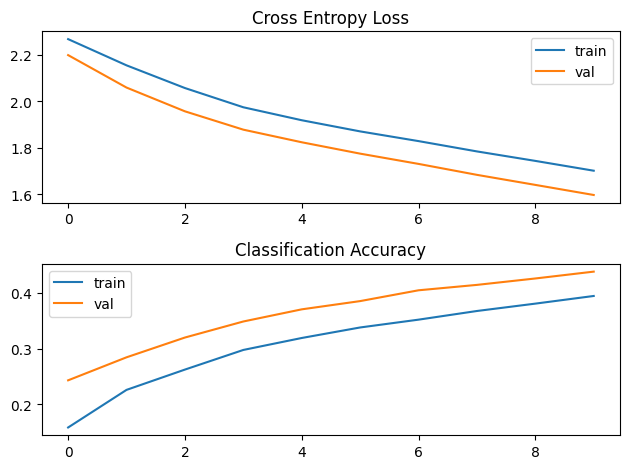

In [8]:
# Train network for 10 epochs
num_epochs = 10
model_name = 'custom CNN'

loss_fn = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(custom_cnn.parameters(), lr=1e-3)

custom_train_history, custom_val_history = train(custom_cnn, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

### 7x7 versus 3x3 Convolutions

Historically, the VGG was the first CNN architecture to introduce more layers (16-19 layers versus the 8 layers of AlexNet) and smaller convolutional kernel sizes (3x3).

This is mainly due to the fact that a stack of 3 3x3 convolutional layers (with stride 1) has the same effective receptive field as a single 7x7 layer. Why?

You can find out more about the effective receptive field of CNNs and explore some visualizations [here](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

Compare the number of parameters of a single convolutional layer with 7x7 kernel with a stack of 3 convolutional layers with 3x3 kernels.

In [ ]:
# TODO
# Use the summary method from the torchsummary package
# Compare one 7x7 convolution layer with three 3x3 layers
# Consider layers with only 1 input and output channels

In [30]:
from torchinfo import summary
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wrap the single Conv2d in Sequential
# Parameters = ((m×n×d)+1)×C -> m, n are the width and height of the filter ; d is the number of input channels and C is the number of layers

model_7x7 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7)
).to(device)

model_3x3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
    nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
).to(device)

''' print("One 7x7 convolution")
summary(model_7x7, input_size=(1, 1, 28, 28), device=device) '''

print("\nThree 3x3 convolutions")
summary(model_3x3, input_size=(1, 1, 28, 28), device=device)



Three 3x3 convolutions


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1, 22, 22]            --
├─Conv2d: 1-1                            [1, 1, 26, 26]            10
├─Conv2d: 1-2                            [1, 1, 24, 24]            10
├─Conv2d: 1-3                            [1, 1, 22, 22]            10
Total params: 30
Trainable params: 30
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

What are the advantages of using a stack of 3
convolutional layers with 3x3 kernels instead of a single 7x7 layer?


- Less parameters needed
- More non linearibility because after each convolutional layer is usually followed by a non-linearity (e.g., ReLU).


## Pre-trained Models - VGG

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.20/models.html)


Load and adapt a VGG-16 model for the CIFAR10 data, through the following steps:
* Load the pre-trained VGG-16 model from torchvision
* Alter the output layer of the network to match the number of classes of the CIFAR10 data (10 classes)

In [8]:
import torch
import torchvision.models as models

# Load VGG model from torchvision
vgg =  models.vgg16(pretrained=True)
vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=10)

vgg.to(device)
print(vgg)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.3MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inspect the model structure.

What does the AdaptiveAvgPool2d layer do?

Start training...

Epoch 1


100%|██████████| 781/781 [00:38<00:00, 20.21it/s]


Train loss: 0.958 	 Train acc: 0.665


100%|██████████| 157/157 [00:04<00:00, 35.16it/s]


Val loss: 0.708 	 Val acc: 0.755

Epoch 2


100%|██████████| 781/781 [00:40<00:00, 19.51it/s]


Train loss: 0.672 	 Train acc: 0.769


100%|██████████| 157/157 [00:04<00:00, 32.97it/s]


Val loss: 0.627 	 Val acc: 0.783

Epoch 3


100%|██████████| 781/781 [00:39<00:00, 19.55it/s]


Train loss: 0.574 	 Train acc: 0.803


100%|██████████| 157/157 [00:04<00:00, 36.66it/s]


Val loss: 0.561 	 Val acc: 0.808

Epoch 4


100%|██████████| 781/781 [00:44<00:00, 17.45it/s]


Train loss: 0.508 	 Train acc: 0.825


100%|██████████| 157/157 [00:05<00:00, 26.26it/s]


Val loss: 0.533 	 Val acc: 0.814

Epoch 5


100%|██████████| 781/781 [00:40<00:00, 19.50it/s]


Train loss: 0.461 	 Train acc: 0.843


100%|██████████| 157/157 [00:04<00:00, 31.99it/s]


Val loss: 0.511 	 Val acc: 0.827

Epoch 6


100%|██████████| 781/781 [00:40<00:00, 19.52it/s]


Train loss: 0.419 	 Train acc: 0.854


100%|██████████| 157/157 [00:04<00:00, 36.82it/s]


Val loss: 0.500 	 Val acc: 0.827

Epoch 7


100%|██████████| 781/781 [00:45<00:00, 17.32it/s]


Train loss: 0.385 	 Train acc: 0.867


100%|██████████| 157/157 [00:07<00:00, 20.87it/s]


Val loss: 0.479 	 Val acc: 0.836

Epoch 8


100%|██████████| 781/781 [00:39<00:00, 19.64it/s]


Train loss: 0.356 	 Train acc: 0.877


100%|██████████| 157/157 [00:04<00:00, 37.83it/s]


Val loss: 0.473 	 Val acc: 0.841

Epoch 9


100%|██████████| 781/781 [00:40<00:00, 19.37it/s]


Train loss: 0.330 	 Train acc: 0.887


100%|██████████| 157/157 [00:05<00:00, 28.32it/s]


Val loss: 0.469 	 Val acc: 0.841

Epoch 10


100%|██████████| 781/781 [00:41<00:00, 18.97it/s]


Train loss: 0.304 	 Train acc: 0.896


100%|██████████| 157/157 [00:04<00:00, 36.86it/s]


Val loss: 0.463 	 Val acc: 0.844
Finished


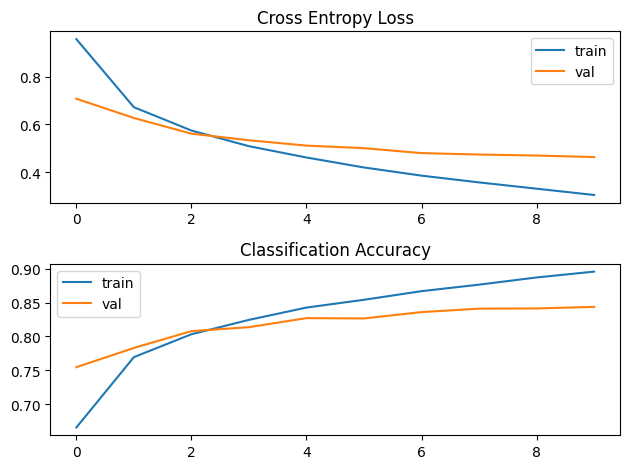

In [36]:
def train_vgg():
  # Train network for 10 epochs
  num_epochs = 10
  model_name = 'vgg16'

  loss_fn = nn.CrossEntropyLoss()
  optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

  vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

  plotTrainingHistory(vgg_train_history, vgg_val_history)

## Pre-trained Models - ResNet

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.20/models.html)


Load and adapt a ResNet-50 model for the CIFAR10 data, through the following steps:
* Load the pre-trained Resnet-50 model from torchvision
* Alter the output layer of the network to match the number of classes of the CIFAR10 data (10 classes)

In [9]:
import torch
import torchvision.models as models

# Load ResNet model from torchvision (with pretrained=True)
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Linear(2048, 10)

resnet.to(device)
print(resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Start training...

Epoch 1


100%|██████████| 781/781 [00:47<00:00, 16.36it/s]


Train loss: 1.698 	 Train acc: 0.415


100%|██████████| 157/157 [00:05<00:00, 27.05it/s]


Val loss: 1.212 	 Val acc: 0.585

Epoch 2


100%|██████████| 781/781 [00:51<00:00, 15.07it/s]


Train loss: 1.051 	 Train acc: 0.636


100%|██████████| 157/157 [00:06<00:00, 25.70it/s]


Val loss: 0.927 	 Val acc: 0.677

Epoch 3


100%|██████████| 781/781 [00:47<00:00, 16.37it/s]


Train loss: 0.845 	 Train acc: 0.709


100%|██████████| 157/157 [00:05<00:00, 29.15it/s]


Val loss: 0.812 	 Val acc: 0.719

Epoch 4


100%|██████████| 781/781 [00:49<00:00, 15.79it/s]


Train loss: 0.717 	 Train acc: 0.752


100%|██████████| 157/157 [00:05<00:00, 31.35it/s]


Val loss: 0.747 	 Val acc: 0.744

Epoch 5


100%|██████████| 781/781 [00:47<00:00, 16.28it/s]


Train loss: 0.627 	 Train acc: 0.784


100%|██████████| 157/157 [00:04<00:00, 32.03it/s]


Val loss: 0.722 	 Val acc: 0.753

Epoch 6


100%|██████████| 781/781 [00:48<00:00, 16.19it/s]


Train loss: 0.557 	 Train acc: 0.809


100%|██████████| 157/157 [00:05<00:00, 29.10it/s]


Val loss: 0.699 	 Val acc: 0.760

Epoch 7


100%|██████████| 781/781 [00:46<00:00, 16.64it/s]


Train loss: 0.491 	 Train acc: 0.832


100%|██████████| 157/157 [00:05<00:00, 27.01it/s]


Val loss: 0.673 	 Val acc: 0.771

Epoch 8


100%|██████████| 781/781 [00:46<00:00, 16.80it/s]


Train loss: 0.430 	 Train acc: 0.853


100%|██████████| 157/157 [00:05<00:00, 27.10it/s]


Val loss: 0.669 	 Val acc: 0.776

Epoch 9


100%|██████████| 781/781 [00:47<00:00, 16.46it/s]


Train loss: 0.379 	 Train acc: 0.870


100%|██████████| 157/157 [00:05<00:00, 28.76it/s]


Val loss: 0.680 	 Val acc: 0.776

Epoch 10


100%|██████████| 781/781 [00:47<00:00, 16.28it/s]


Train loss: 0.336 	 Train acc: 0.886


100%|██████████| 157/157 [00:04<00:00, 32.20it/s]


Val loss: 0.675 	 Val acc: 0.784
Finished


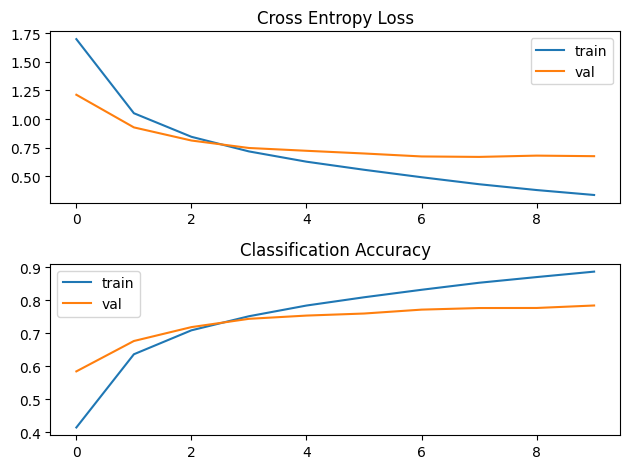

In [40]:
def train_res():
  # Train network for 10 epochs
  num_epochs = 10
  model_name = 'resnet50'

  loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
  optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

  resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

  plotTrainingHistory(resnet_train_history, resnet_val_history)

### Compare the VGG and ResNet models in terms of:


1.   number of parameters
2.   validation accuracy
3.   training time

What is the main difference introduced by the ResNet architecture?


In [ ]:
# TODO: use torchsummary to compare VGG-16 and ResNet-50
# Resnet arcihtecture uses much less parameters ; they are similar in terms of training time and accuracy - in terms of architectural structure the difference in resnet comes from the fact that ResNet (Residual Network) architecture is the use of residual connections (also known as skip connections).

ResNet-50 Parameters: 23,528,522
VGG-16 Parameters: 134,301,514
Start training...

Epoch 1


100%|██████████| 781/781 [00:45<00:00, 16.98it/s]


Train loss: 0.285 	 Train acc: 0.904


100%|██████████| 157/157 [00:05<00:00, 27.16it/s]


Val loss: 0.683 	 Val acc: 0.785

Epoch 2


100%|██████████| 781/781 [00:45<00:00, 17.04it/s]


Train loss: 0.245 	 Train acc: 0.919


100%|██████████| 157/157 [00:05<00:00, 27.11it/s]


Val loss: 0.697 	 Val acc: 0.788

Epoch 3


100%|██████████| 781/781 [00:45<00:00, 17.20it/s]


Train loss: 0.211 	 Train acc: 0.931


100%|██████████| 157/157 [00:05<00:00, 27.81it/s]


Val loss: 0.721 	 Val acc: 0.785

Epoch 4


100%|██████████| 781/781 [00:45<00:00, 17.27it/s]


Train loss: 0.186 	 Train acc: 0.939


100%|██████████| 157/157 [00:05<00:00, 27.25it/s]


Val loss: 0.725 	 Val acc: 0.789

Epoch 5


100%|██████████| 781/781 [00:45<00:00, 17.27it/s]


Train loss: 0.159 	 Train acc: 0.949


100%|██████████| 157/157 [00:05<00:00, 27.80it/s]


Val loss: 0.759 	 Val acc: 0.788

Epoch 6


100%|██████████| 781/781 [00:45<00:00, 17.22it/s]


Train loss: 0.139 	 Train acc: 0.955


100%|██████████| 157/157 [00:05<00:00, 27.97it/s]


Val loss: 0.769 	 Val acc: 0.790

Epoch 7


100%|██████████| 781/781 [00:45<00:00, 17.33it/s]


Train loss: 0.123 	 Train acc: 0.961


100%|██████████| 157/157 [00:05<00:00, 27.15it/s]


Val loss: 0.789 	 Val acc: 0.789

Epoch 8


100%|██████████| 781/781 [00:45<00:00, 17.30it/s]


Train loss: 0.107 	 Train acc: 0.966


100%|██████████| 157/157 [00:05<00:00, 28.04it/s]


Val loss: 0.805 	 Val acc: 0.789

Epoch 9


100%|██████████| 781/781 [00:45<00:00, 17.32it/s]


Train loss: 0.093 	 Train acc: 0.971


100%|██████████| 157/157 [00:05<00:00, 27.37it/s]


Val loss: 0.809 	 Val acc: 0.793

Epoch 10


100%|██████████| 781/781 [00:45<00:00, 17.32it/s]


Train loss: 0.083 	 Train acc: 0.974


100%|██████████| 157/157 [00:05<00:00, 29.01it/s]


Val loss: 0.842 	 Val acc: 0.794
Finished


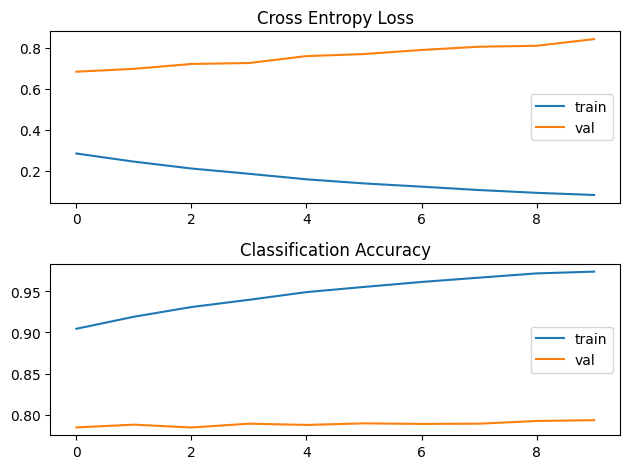

Final Resnet-50 Validation Accuracy: 0.79
ResNet training time: 513.53 seconds
Start training...

Epoch 1


100%|██████████| 781/781 [00:38<00:00, 20.22it/s]


Train loss: 1.085 	 Train acc: 0.624


100%|██████████| 157/157 [00:04<00:00, 38.50it/s]


Val loss: 0.727 	 Val acc: 0.744

Epoch 2


100%|██████████| 781/781 [00:38<00:00, 20.15it/s]


Train loss: 0.685 	 Train acc: 0.764


100%|██████████| 157/157 [00:05<00:00, 30.93it/s]


Val loss: 0.619 	 Val acc: 0.786

Epoch 3


100%|██████████| 781/781 [00:38<00:00, 20.11it/s]


Train loss: 0.578 	 Train acc: 0.800


100%|██████████| 157/157 [00:05<00:00, 30.76it/s]


Val loss: 0.568 	 Val acc: 0.804

Epoch 4


100%|██████████| 781/781 [00:38<00:00, 20.24it/s]


Train loss: 0.512 	 Train acc: 0.823


100%|██████████| 157/157 [00:04<00:00, 38.03it/s]


Val loss: 0.541 	 Val acc: 0.813

Epoch 5


100%|██████████| 781/781 [00:38<00:00, 20.08it/s]


Train loss: 0.461 	 Train acc: 0.842


100%|██████████| 157/157 [00:04<00:00, 35.98it/s]


Val loss: 0.510 	 Val acc: 0.824

Epoch 6


100%|██████████| 781/781 [00:38<00:00, 20.14it/s]


Train loss: 0.420 	 Train acc: 0.854


100%|██████████| 157/157 [00:04<00:00, 31.81it/s]


Val loss: 0.493 	 Val acc: 0.830

Epoch 7


100%|██████████| 781/781 [00:38<00:00, 20.23it/s]


Train loss: 0.385 	 Train acc: 0.866


100%|██████████| 157/157 [00:04<00:00, 37.43it/s]


Val loss: 0.478 	 Val acc: 0.838

Epoch 8


100%|██████████| 781/781 [00:38<00:00, 20.25it/s]


Train loss: 0.356 	 Train acc: 0.878


100%|██████████| 157/157 [00:04<00:00, 38.34it/s]


Val loss: 0.481 	 Val acc: 0.836

Epoch 9


100%|██████████| 781/781 [00:38<00:00, 20.22it/s]


Train loss: 0.326 	 Train acc: 0.887


100%|██████████| 157/157 [00:05<00:00, 30.60it/s]


Val loss: 0.472 	 Val acc: 0.843

Epoch 10


100%|██████████| 781/781 [00:38<00:00, 20.14it/s]


Train loss: 0.304 	 Train acc: 0.896


100%|██████████| 157/157 [00:04<00:00, 31.77it/s]


Val loss: 0.457 	 Val acc: 0.847
Finished


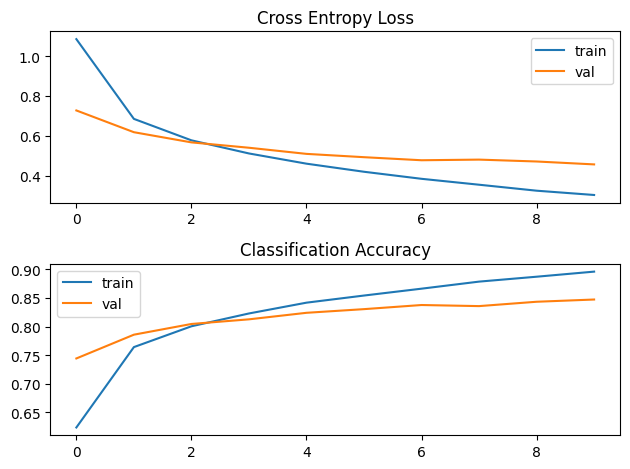

Final VGG-16 Validation Accuracy: 0.85
VGG training time: 478.96 seconds


In [11]:
import time


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_res():
  # Train network for 10 epochs
  num_epochs = 10
  model_name = 'resnet50'

  loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
  optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

  resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

  plotTrainingHistory(resnet_train_history, resnet_val_history)

  final_acc = resnet_val_history["accuracy"][-1]  # Last epoch's val accuracy
  print(f"Final Resnet-50 Validation Accuracy: {final_acc:.2f}")


def train_vgg():
  # Train network for 10 epochs
  num_epochs = 10
  model_name = 'vgg16'

  loss_fn = nn.CrossEntropyLoss()
  optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

  vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

  plotTrainingHistory(vgg_train_history, vgg_val_history)

  final_acc = vgg_val_history["accuracy"][-1]  # Last epoch's val accuracy
  print(f"Final VGG-16 Validation Accuracy: {final_acc:.2f}")


print(f"ResNet-50 Parameters: {count_params(resnet):,}")
print(f"VGG-16 Parameters: {count_params(vgg):,}")

''' final_acc_resnet = resnet_val_history['acc'][-1]
final_acc_vgg = vgg_val_history['acc'][-1]

print(f"ResNet-50 Final Val Accuracy: {final_acc_resnet:.2f}")
print(f"VGG-16 Final Val Accuracy: {final_acc_vgg:.2f}") '''


start_time = time.time()
train_res()
print(f"ResNet training time: {time.time() - start_time:.2f} seconds")
start_time = time.time()
train_vgg()
print(f"VGG training time: {time.time() - start_time:.2f} seconds")



## Challenges

**Challenge 1:** In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

**Challenge 2:** Experiment with other CNN architectures available on torchvision.